# Evaluation of PAAM static offset angle for correctness 

You can alway view this page at https://mybinder.org/v2/gh/eliasbreunig/PAA_analysis/main?urlpath=tree/paa_angles.ipynb

Read the cover document [here](./LISA-AEI-IDS-PAAM-TN-XXXX-LATEST.pdf) !

The purpose of this notebook is to assert the correctness of the PAAM static offset angle requirement w.r.t to the PAA IRD requirement in a quantitative and unambiguous way.
This is achieved by implementing a minimalistic raytracer with as little as possible external dependencies, so that the correctness of the procedure can be verified within the bounds of this single notebook.

The translation component of the transformations between e.g. SC and MOSA are only for illustration purposes and do not affect the result, as the raytrace is limited to angular space. 

The requirement for the point ahead angle static offset is given in the IDS.IRD as: 

In [339]:
required_PAA_RZ_OB = -221.1e-6  

This value is given on the OB frame of reference (OB MRF).

## Imports and Initializations

In [340]:
%matplotlib widget
import numpy as np
from numpy import cos, sin
from matplotlib import pyplot

# to build and manage the scenegraph we use the paytransform3d library
from pytransform3d.transform_manager import TransformManager 

# init the scenegraph
sg = TransformManager()

# define axis indices
X, Y, Z = (0, 1, 2)

In [341]:
# Helper code for transparent transformation matrices

def frame_transformation(translation_vector, rotation_axis: int, rotation_angle: float):

    ''' return an alias transformation matrix in homogenous coordinates which applies a translation followed
     by a rotation, both relative to the parent coordinate frame. Because of frame transformation convention
     rotation and translation get inverted along the way.'''
    
    ra: float = -rotation_angle

    translation = np.identity(4) 
    
    translation[0][3] = -translation_vector[0] 
    translation[1][3] = -translation_vector[1]
    translation[2][3] = -translation_vector[2]
    
    if rotation_axis == 0: # X

        rotation = np.array([[1,        0      ,  0       ],
                             [0,        cos(ra), -sin(ra) ],
                             [0,        sin(ra),  cos(ra) ]])

    elif rotation_axis == 1: # Y

        rotation = np.array([[ cos(ra), 0      , sin(ra) ],
                             [ 0      , 1.     ,       0 ],
                             [-sin(ra), 0      , cos(ra) ]])
        
    elif rotation_axis == 2: # Z

        rotation = np.array([[ cos(ra), -sin(ra),       0 ],
                             [ sin(ra), cos(ra) ,       0 ],
                             [ 0      , 0       ,       1 ]])

    else:
        raise ValueError
    
    # add row/colum 4 for homogoenous coordinate convention

    rotation = np.append(rotation, [[0,0,0]],0)
    rotation = np.append(rotation, [[0],[0],[0],[1]],1)

    return rotation @ translation   

def reflection_matrix(surface_normal):

    # convert array to vector and normalize in case the surface normal is not yet a unit vector
    surface_normal = surface_normal.reshape(-1, 1)/np.linalg.norm(surface_normal)

    # assemble and return the full reflection matrix
    return np.identity(3) - 2*(surface_normal @ surface_normal.T)



## Definitions of Coordinate Frames
All units are [m] and [rad] 

In [342]:
# Definition of:
# the MOSA frame relative to the SC frame (rotation of 30deg aroung Z to match constellation angle plus some arbitrary translation)

sc2mosa1_trafo = frame_transformation([0,1,0],Z,30./180.*np.pi)

# the OB frame relative to the MOSA frame (just a translation along X)
mosa2ob_trafo = frame_transformation([0.5,0,0],0,0)

# the PAAM frame relative to the OB frame (achieved with a tranlation and two rotations)
ob2paam_trafo_1 = frame_transformation([0.0,0.05,-0.12],X, -135./180.*np.pi)
ob2paam_trafo_2 = frame_transformation([0,0,0],Y, 90./180.*np.pi)

ob2paam_trafo = ob2paam_trafo_2 @ ob2paam_trafo_1

# add the transformations to the scenegraph
sg.add_transform("SC","MOSA", sc2mosa1_trafo)
sg.add_transform("MOSA","OB", mosa2ob_trafo)
sg.add_transform("OB","PAAM_OIRF", ob2paam_trafo)

# variable transformation that defines the PAAM mirror frame based on static offset rotation around PAAM OIRF Y (ETA)
apply_paam_static_rotation =  lambda rot: sg.add_transform("PAAM_OIRF","PAAM_Mirror", frame_transformation([0,0,0],Y, rot)) 

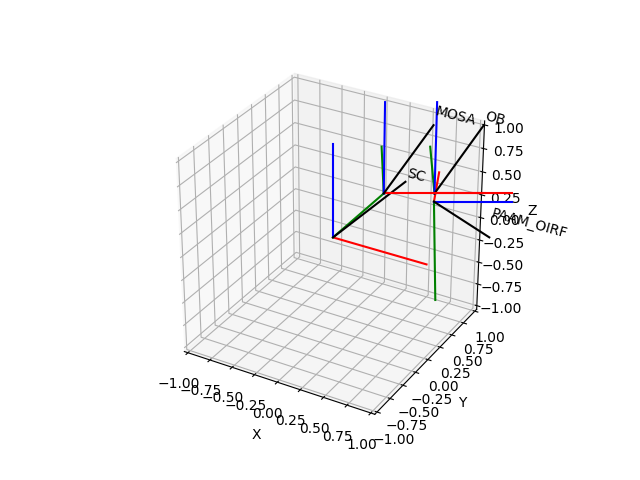

In [343]:
pyplot.figure()
ax = sg.plot_frames_in("SC", s=1)
pyplot.show()

Figure 1: Visualization of the Coordinate Frames below the SC Frame as defined previously (this view is interactive!)

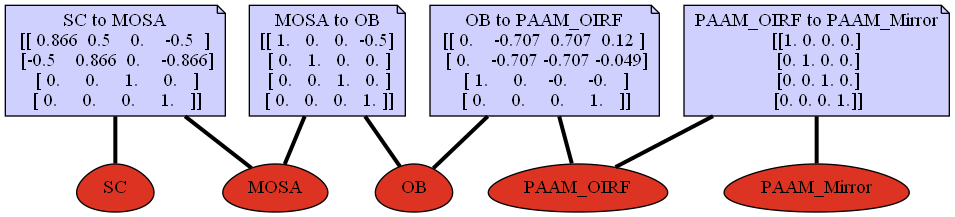

In [344]:
apply_paam_static_rotation(0.0)
sg.write_png("test.png")

from IPython.display import Image
Image("test.png")

Figure 2: Explicit listing of all defined transformations

## Raytrace inside OB Frame
### Definition of the tracing function

In [345]:
def trace_paam_effect(paam_static_rot=0, getrace=False):

    ''' this function implements the trace from the pre-paam beam up to the 
    exit from the OBA. All reflection are handled in the OB frame of reference
    The function accepts the following parameters
    
    paam_static_rot: rotation angle in radians of the paam around paam y
    gertrace: bool, request additional tracing output for visualization'''

    # define all surface normals of the reflecting elements in the OB frame (refer to OB Layout V2.2.2)

    beam_pre_paam_OB = np.array([ 0.0,   1.0,    0.0 ])
    pbs1_normal_OB   = np.array([ 0.0,  -1.0,   -1.0 ])
    telif_normal_OB  = np.array([ 1.0,   1.0,    0.0 ])

    # apply paam static offset in paam OIRF RY

    apply_paam_static_rotation(paam_static_rot)
    
    # Compute PAAM mirror normal in OB frame

    paam_normal_OB= (sg.get_transform("PAAM_Mirror","OB") @ np.array([1,   0,  0, 0]))[0:3] # PAAM Mirror normal in Mirror COS is 1,0,0

    # Generate Reflection Matrices from normal vectors

    paam_reflection_OB  = reflection_matrix(paam_normal_OB)
    pbs1_reflection_OB  = reflection_matrix(pbs1_normal_OB)
    telif_reflection_OB = reflection_matrix(telif_normal_OB)

    # matrix multiply initial beam direction according to optical sequence

    tx_beam_exit_OB = telif_reflection_OB @ pbs1_reflection_OB @ paam_reflection_OB @ beam_pre_paam_OB

    if getrace:
        pass # not implemented yet
    else:
        return tx_beam_exit_OB #return the final beam direction

### Execute analysis

In [346]:
paam_rotation_PAAM_OIRF_RY = required_PAA_RZ_OB/2**0.5

print(f"A rotation of {paam_rotation_PAAM_OIRF_RY} has been applied as static offset to the paam (Ry)")

tx_original_exit_OB = trace_paam_effect() # trace without applied paam offset
tx_mod_exit_OB = trace_paam_effect(paam_rotation_PAAM_OIRF_RY)  ## -156.27 matching the current requirement
tx_rotation_OB = np.cross(tx_original_exit_OB, tx_mod_exit_OB) # compute point ahead rotation in OB frame between the two beams

A rotation of -0.00015634130932034565 has been applied as static offset to the paam (Ry)


## Postprocessing
### in OB frame

In [347]:
print(f"original beam : {tx_original_exit_OB}")
print(f"offset beam   : {tx_mod_exit_OB}")
print(f"rotation      : {tx_rotation_OB}")
print("Check for requirement in OB Frame:")
print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose(rotation[2],required_PAA_RZ_OB, atol=1e-6)])


original beam : [ 1.00000000e+00 -3.08640211e-16  4.44089210e-16]
offset beam   : [ 9.99999976e-01 -2.21099996e-04 -2.44426045e-08]
rotation      : [ 9.81956667e-20  2.44426049e-08 -2.21099996e-04]
Check for requirement in OB Frame:
The static offset pointing is compliant


### in SC frame

In [348]:

print("Check for requirement in SC Frame:")

OB2SC_trafo = sg.get_transform("OB","SC")[0:3,0:3] # for convienience we use only the rotation matrix part

print(f"original beam : {OB2SC_trafo @ tx_original_exit_OB}")
print(f"offset beam   : {OB2SC_trafo @ tx_mod_exit_OB}")
print(f"rotation      : {OB2SC_trafo @ tx_rotation_OB}")

print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose((OB2SC_trafo @ tx_rotation_OB)[2],required_PAA_RZ_OB,atol=1e-6)])


Check for requirement in SC Frame:
original beam : [8.66025404e-01 5.00000000e-01 4.44089210e-16]
offset beam   : [ 8.66135933e-01  4.99808510e-01 -2.44426045e-08]
rotation      : [-1.22213025e-08  2.11679168e-08 -2.21099996e-04]
The static offset pointing is compliant


The requirement of -221µrad rotation around Z in OB frame is met, nota bene: the secondary effect is 4 orders of magnitude smaller, a 0.2µrad rotation around y which is small enough to be neglected in the alignment budget.
For this to verify also beyond OB frame, it needs to be enforced that OB Z is coalligned with MOSA and SC Z.

# Tests
## Some sanity checks

In [349]:
# plot the trace in 3d with the coordinate frames visualized

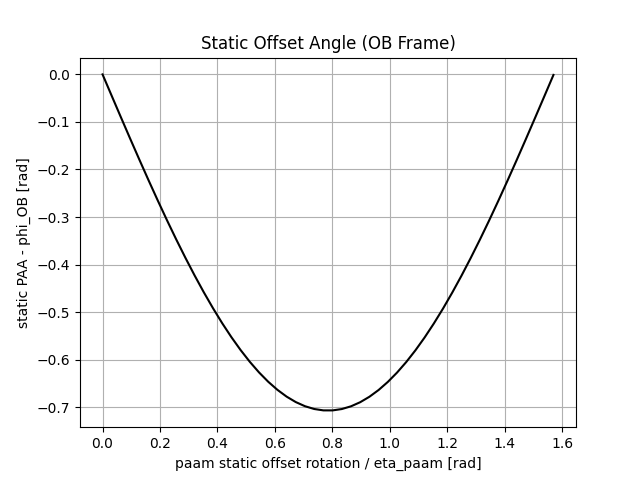

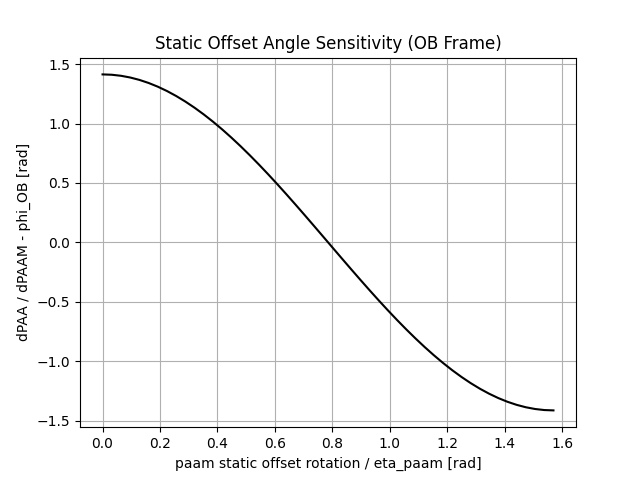

In [350]:
rotation_OB_z = [np.cross(tx_original_exit_OB, trace_paam_effect(rot))[-1] for rot in np.linspace(0,-3.14/2)]

pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),rotation_OB_z, 'black')
pyplot.title("Static Offset Angle (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("static PAA - phi_OB [rad]")
pyplot.grid("Both")
pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),np.gradient((rotation_OB_z),np.linspace(0,-3.14/2)), 'black')
pyplot.title("Static Offset Angle Sensitivity (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("dPAA / dPAAM - phi_OB [rad]")
pyplot.grid("Both")

## Additional Unit-Tests